# Analiza nieruchomości w Krakowie, wystawionych na sprzedaż w serwisie *otodom.pl*
Analizowane są wszystkie pozycje wyświetlane po zastosowaniu filtu "Rodzaj zabudowy: Dom".  
Na dzień 02.04.2024 dostępne są 4 strony wyników (maksymalnie po 36 elementów na stronie).  
Autor: **Oliwier Stręk**

Importujemy niezbędne biblioteki.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import zipfile
import geopandas
import re
import os
import matplotlib.pyplot as plt

Pobieramy dane z serwisu *otodom.pl* - w tym celu iterujemy po stronach wyników i zapisujemy je w liście _pages_.

In [2]:
url = "https://www.otodom.pl/pl/wyniki/sprzedaz/mieszkanie/malopolskie/krakow/krakow/krakow?limit=36&ownerTypeSingleSelect=ALL&buildingType=%5BHOUSE%5D&by=DEFAULT&direction=DESC&viewType=listing&page="

pages = []
for page_number in range(1, 5):
    print(f'Pobieranie strony nr {page_number}')
    response = requests.get(f'{url}{page_number}', headers={
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36'})
    processed_page = BeautifulSoup(response.content, "html.parser")
    pages.append(processed_page)

Pobieranie strony nr 1
Pobieranie strony nr 2
Pobieranie strony nr 3
Pobieranie strony nr 4


Przechodzimy do ekstrakcji tylko tych klas, które zawierają oferty domów.

In [4]:
full_house_data = []
for page in pages:
    full_house_data += page.find_all(class_='css-136g1q2 e88tro00')

Teraz z każdej interesującej nas klasy "wydłubujemy" informacje:
- tytuł oferty
- ilość pokoi
- powierzchnia domu
- cena za metr kwadratowy
- całkowita cena za nieruchomość
- kto wystawił ofertę
- dzielnica, w której znajduje się nieruchomość

In [6]:
houses = []
for house_html in full_house_data:
    house = {'title': house_html.find(class_='css-3czwt4 e1dhq2er0').text.strip()}

    rooms = house_html.find(class_='css-uki0wd e12r8p6s1').text.strip()
    begIdx = rooms.find('pokoi') + 5
    endIdx = begIdx + 1
    house['rooms'] = int(rooms[begIdx:endIdx])

    area = house_html.find(class_='css-uki0wd e12r8p6s1').text.strip()
    begIdx = area.find('chnia') + 5
    endIdx = area.find('m²')
    house['area'] = float(area[begIdx:endIdx])

    price = house_html.find(class_='css-uki0wd e12r8p6s1').text.strip()
    begIdx = price.find('y') + 1
    endIdx = price.find('zł')
    house['price / m2'] = int(price[begIdx:endIdx].replace('\xa0', '').replace(' ', ''))

    house['total price'] = int(
        house_html.find(class_='css-1uwck7i e1a3ad6s0').text.strip().replace('\xa0', '').replace(' ', '').replace('zł',
                                                                                                                  ''))

    try:
        vendor_type = house_html.find(class_='css-7rx3ki e1ipr7st2').text
        begIdx = vendor_type.find('Oferta prywatna')
        if begIdx == -1:
            begIdx = vendor_type.find('Biuro nieruchomości')
            if begIdx == -1:
                house['vendor type'] = 'Deweloper'
            else:
                house['vendor type'] = 'Biuro nieruchomości'
        else:
            house['vendor type'] = 'Oferta prywatna'
    except (AttributeError, TypeError):
        house['vendor type'] = 'SOMETHING WENT WRONG :/'

    district = house_html.find(class_='css-1dvtw4c e12u5vlm0').text.strip()
    begIdx = district.find(', ') + 2
    endIdx = district.find(', Kraków')
    district = district[begIdx:endIdx]
    begIdx = district.find(', ') + 1
    if begIdx != -1:
        district = district[begIdx:].strip()
    if len(district) > 24:
        district = 'KRAKÓW - OBRZEŻA'
    house['district'] = district.upper()

    houses.append(house)

Usuwamy pierwsze 3 elementy, które są reklamami i nie spełniają naszych kryteriów.  
Tworzymy i wyświetlamy DataFrame z listy _houses_.

In [8]:
del houses[0]
del houses[0]
del houses[0]

df = pd.DataFrame(houses)
df

,title,rooms,area,price / m2,total price,vendor type,district
0,"Unikatowe Mieszkanie, 2x garaże, piwnica, balkon",3,82.00,17061,1399000,Biuro nieruchomości,STARE MIASTO
1,TWOJE MIESZKANIE BLISKO NATURY 0%PROWIZJI,4,67.00,9836,659000,Oferta prywatna,PRĄDNIK BIAŁY
2,"Kawalerka 12,4m2+ balkon.",1,12.30,14228,175000,Oferta prywatna,BIEŻANÓW-PROKOCIM
3,"Apartament 24,3m2, Otwinowskiego Residence",1,24.30,12305,299000,Oferta prywatna,GRZEGÓRZKI
4,"Kawalerka 17,5m2, Nowa inwestycja",1,17.50,12286,215000,Oferta prywatna,BIEŻANÓW-PROKOCIM
...,...,...,...,...,...,...,...
131,"Ekskluzywny dom, Garaż, Prestiżowa dzielnica",4,124.45,17049,2121800,Biuro nieruchomości,ZWIERZYNIEC
132,"Gotowy Luksusowy Bliźniak, Duży taras, Promocja",4,124.45,15765,1962000,Biuro nieruchomości,ZWIERZYNIEC
133,2 piętra_duży taras i ogród_Kameralne osiedle,3,68.84,13631,938351,Biuro nieruchomości,BRONOWICE
134,Mieszkanie na sprzedaż w Podgórzu !!!,6,166.30,3001,499000,Biuro nieruchomości,BIEŻANÓW-PROKOCIM


Grupujemy dane po dzielnicach i zliczamy ilość ofert w każdej z nich, następnie wyświetlamy.

In [9]:
df_district = df.groupby('district').size().to_frame()
df_district.columns = ['qty']
df_district

,qty
district,
BIEŻANÓW-PROKOCIM,11
BRONOWICE,4
CZYŻYNY,3
DĘBNIKI,5
GRZEGÓRZKI,7
KRAKÓW - OBRZEŻA,5
KROWODRZA,2
NOWA HUTA,2
PODGÓRZE,6


Tworzymy funkcję _zip_read()_, która pozwoli nam na odczytanie plików z rozszerzeniem _.zip_.

In [10]:
def read_zipfile(zip_filename, entry_name):
    zip_file = zipfile.ZipFile(zip_filename, mode="r")
    dbf_name = list(filter(lambda x: re.match(entry_name + r'.*\.dbf$', os.path.basename(x)), zip_file.namelist()))[0]
    zip_file.close()

    return geopandas.read_file(dbf_name, encoding='utf-8', vfs='zip://' + zip_filename)

Teraz ze strony _gis-support.pl_ pobieramy plik _dzielnice_Krakowa.zip_, który zawiera dane o dzielnicach Krakowa.

In [11]:
url = 'https://gis-support.pl/wp-content/uploads/dzielnice_Krakowa.zip'

response = requests.get(url, allow_redirects=True)
open('dzielnice_Krakowa.zip', 'wb').write(response.content)

districts = read_zipfile('dzielnice_Krakowa.zip', 'dzielnice_Krakowa')
districts = districts.rename(columns={'nazwa': 'dzielnica'})
districts['dzielnica'] = districts['dzielnica'].str.upper()

Mając już odczytane dane o dzielnicach Krakowa, dodajemy do nich informację o ilości ofert w danej dzielnicy.

In [12]:
df_district_qty = pd.merge(districts, df_district, left_on='dzielnica', right_index=True)
df_district_qty.sort_values('qty', ascending=False)

,objectid,mslink,mapid,id_dzielni,nr_dzielni,powierzchn,dzielnica,nazwa_peln,opis,data_aktua,st_area(sh,st_length(,geometry,qty
6,7.0,7.0,3013.0,7.0,VII,28730964.0,ZWIERZYNIEC,Dzielnica VII Zwierzyniec,UCHWAŁA NR XCIX/1501/14 RADY MIASTA KRAKOWA,2014-04-01,2.873096e+07,27402.249557,"POLYGON ((557355.217 244969.030, 557369.220 24...",43
3,4.0,4.0,3013.0,4.0,IV,23418679.0,PRĄDNIK BIAŁY,Dzielnica IV Prądnik Biały,UCHWAŁA NR XCIX/1498/14 RADY MIASTA KRAKOWA,2014-04-01,2.341868e+07,29388.178117,"POLYGON ((561609.805 249100.253, 561714.891 24...",17
9,10.0,10.0,3013.0,10.0,X,25604010.0,SWOSZOWICE,Dzielnica X Swoszowice,UCHWAŁA NR XCIX/1504/14 RADY MIASTA KRAKOWA,2014-04-01,2.560401e+07,33120.757283,"POLYGON ((563480.973 235645.246, 563486.811 23...",13
11,12.0,12.0,3013.0,12.0,XII,18473911.0,BIEŻANÓW-PROKOCIM,Dzielnica XII Bieżanów-Prokocim,UCHWAŁA NR XCIX/1506/14 RADY MIASTA KRAKOWA,2014-04-01,1.847391e+07,23634.825933,"POLYGON ((569666.048 239153.774, 569669.023 23...",11
8,9.0,9.0,3013.0,9.0,IX,5415081.0,ŁAGIEWNIKI-BOREK FAŁĘCKI,Dzielnica IX Łagiewniki-Borek Fałęcki,UCHWAŁA NR XCIX/1503/14 RADY MIASTA KRAKOWA,2014-04-01,5.415081e+06,11876.558422,"POLYGON ((564972.632 238410.627, 564976.023 23...",10
1,2.0,2.0,3013.0,2.0,II,5845232.0,GRZEGÓRZKI,Dzielnica II Grzegórzki,UCHWAŁA NR XCIX/1496/14 RADY MIASTA KRAKOWA,2014-04-01,5.845232e+06,11863.161038,"POLYGON ((567784.500 244043.139, 567786.287 24...",7
12,13.0,13.0,3013.0,13.0,XIII,25667082.0,PODGÓRZE,Dzielnica XIII Podgórze,UCHWAŁA NR XCIX/1507/14 RADY MIASTA KRAKOWA,2014-04-01,2.566708e+07,34696.015083,"POLYGON ((566385.478 241086.274, 566390.281 24...",6
7,8.0,8.0,3013.0,8.0,VIII,46188703.0,DĘBNIKI,Dzielnica VIII Dębniki,UCHWAŁA NR XCIX/1502/14 RADY MIASTA KRAKOWA,2014-04-01,4.618870e+07,40805.960206,"POLYGON ((556746.136 238581.515, 556750.361 23...",5
5,6.0,6.0,3013.0,6.0,VI,9559587.0,BRONOWICE,Dzielnica VI Bronowice,UCHWAŁA NR XCIX/1500/14 RADY MIASTA KRAKOWA,2014-04-01,9.559587e+06,15472.481141,"POLYGON ((559680.480 247139.293, 559681.829 24...",4
13,14.0,14.0,3013.0,14.0,XIV,12256767.0,CZYŻYNY,Dzielnica XIV Czyżyny,UCHWAŁA NR XCIX/1508/14 RADY MIASTA KRAKOWA,2014-04-01,1.225677e+07,20395.745226,"POLYGON ((570051.983 246991.812, 570055.463 24...",3


Mając już wszystie potrzebne dane, możemy przystąpić do wizualizacji.
Tworzymy wykres (w postaci mapy Krakowa, podzielonej na dzielnice), który przedstawia liczbę ogłoszeń przypadających na poszczególne dzielnice miasta.

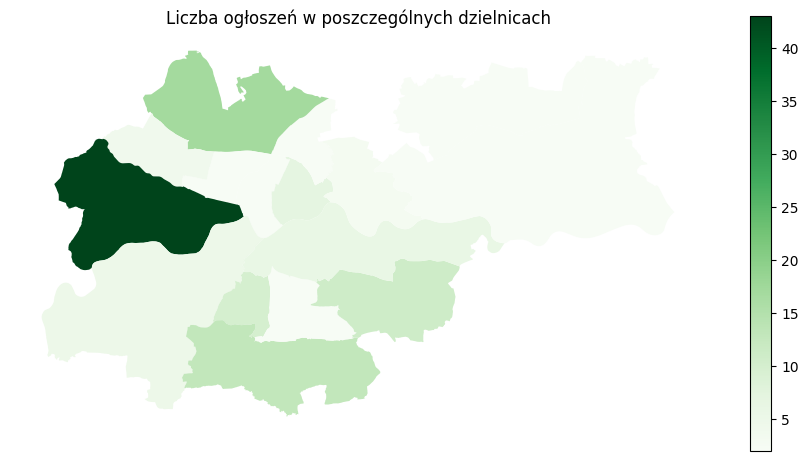

In [13]:
fig, ax = plt.subplots(figsize=(9, 9))
df_district_qty.plot(column='qty', cmap='Greens', linewidth=1.5, ax=ax)

vmin, vmax = df_district_qty['qty'].min(), df_district_qty['qty'].max()
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, shrink=0.5, ax=ax)

ax.grid(True)
ax.set_axis_off()
ax.set_title("Liczba ogłoszeń w poszczególnych dzielnicach")

plt.tight_layout()
plt.show()

Teraz wyświetlamy wykres, który przedstawia te same dane, ale w postaci słupkowej.

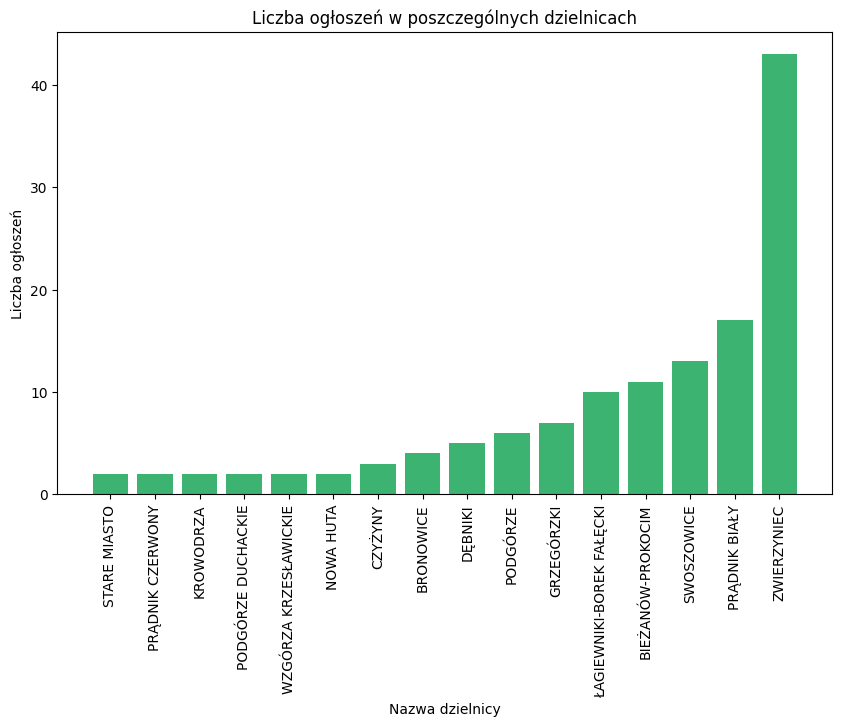

In [14]:
df_district_qty_asc = df_district_qty.sort_values('qty', ascending=True)
plt.figure(figsize=(10, 6))
plt.bar(df_district_qty_asc['dzielnica'], df_district_qty_asc['qty'], color='mediumseagreen')
plt.title('Liczba ogłoszeń w poszczególnych dzielnicach')
plt.xlabel('Nazwa dzielnicy')
plt.ylabel('Liczba ogłoszeń')
plt.xticks(rotation=90)
plt.show()

Na koniec tworzymy kilka dodatkowych wykresów, które przedstawiają inne informacje na temat sprzedawanych nieruchomości w Krakowie.

Text(0, 0.5, 'Ilość ofert')

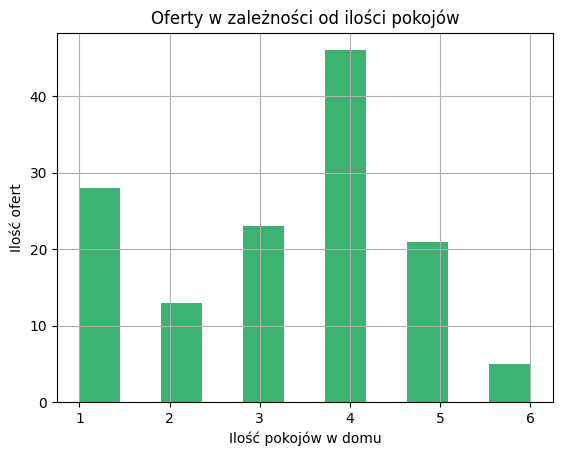

In [15]:
df.hist(column='rooms', bins=11, color='mediumseagreen')
plt.title('Oferty w zależności od ilości pokojów')
plt.xlabel('Ilość pokojów w domu')
plt.ylabel('Ilość ofert')

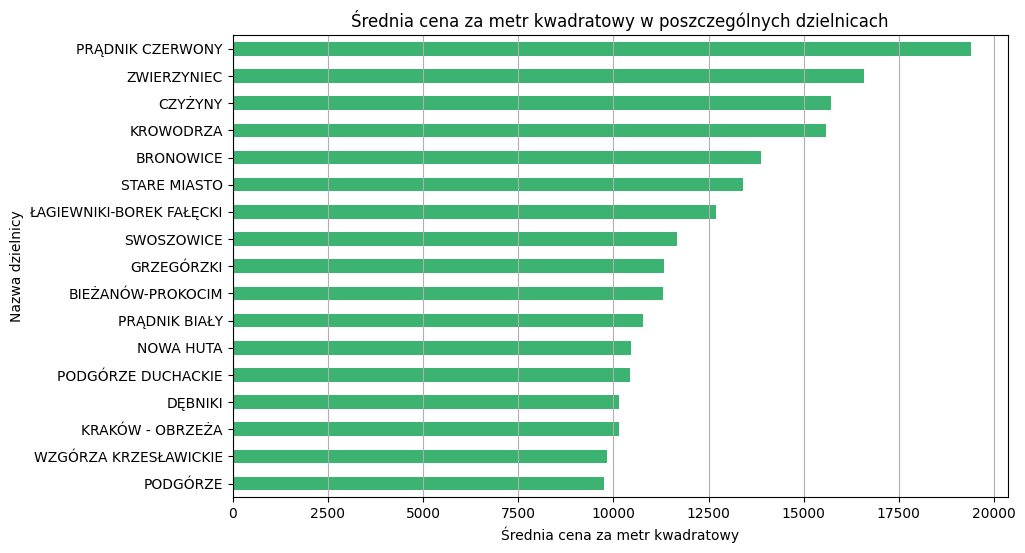

In [16]:
avg_price = df.groupby('district')['price / m2'].mean().sort_values()
plt.figure(figsize=(10, 6))
avg_price.plot(kind='barh', color='mediumseagreen')
plt.title('Średnia cena za metr kwadratowy w poszczególnych dzielnicach')
plt.xlabel('Średnia cena za metr kwadratowy')
plt.ylabel('Nazwa dzielnicy')
plt.grid(axis='x')
plt.show()

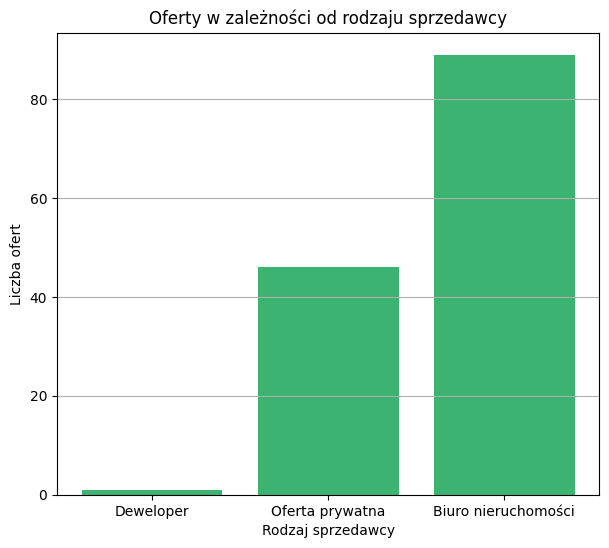

In [17]:
df_vendor = df.groupby('vendor type').size().to_frame().sort_values(0, ascending=True)
df_vendor.columns = ['qty']
plt.figure(figsize=(7, 6))
plt.bar(df_vendor.index, df_vendor['qty'], color=['mediumseagreen'])
tmp = df_vendor['qty'].sum()
plt.title('Oferty w zależności od rodzaju sprzedawcy')
plt.xlabel('Rodzaj sprzedawcy')
plt.ylabel('Liczba ofert')
plt.grid(axis='y')
plt.show()